In [2]:
import pickle
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [3]:
def get_chords(nr,Γ):
    chords = []

    # ---- Register all valid chords ---- #
    for start_idx in range(len(Γ)):
        for end_idx in range(start_idx + 2, len(Γ)):

            # ---- Chord equation ---- #
            a = (Γ[end_idx] - Γ[start_idx]) / (nr[end_idx] - nr[start_idx])
            b = (Γ[start_idx]*nr[end_idx] - Γ[end_idx]*nr[start_idx]) / (nr[end_idx] - nr[start_idx])

            # ---- Chord under the energy everywhere ? ---- #
            for middle_idx in range(start_idx + 1, end_idx):
                if Γ[middle_idx] < a*nr[middle_idx] + b:
                    break
            else:
                chords.append((start_idx, end_idx))

    final_chords = []

    # ---- Test if the chord is included in another ---- #
    for chord in chords:
        for test_chord in chords:
            if chord == test_chord:
                continue
            if test_chord[0] <= chord[0] and chord[1] <= test_chord[1]:
                break
        else:
            final_chords.append(chord)

    return final_chords

In [4]:
def get_interpreted_data(res_dict, twoD=True,only_qq=False):
    #The dictionnary below contains the phase with the least energy. It is either "para" or a tuple (Qx, Qy)
    #If the phase with least energy should be magnetized but has magnetization 0, "para" is chosen instead
    phase_dict = dict()
    mag_dict = dict()
    e_dict = dict()
    mu_dict = dict()
    phase_type = ["para","qq"] if only_qq else (["para", "q0", "piq", "qq"] if twoD \
                                                else ["para", "00q", "0qq", "qqq", "pipiq","piqq","0piq"])

    n_set = set()
    T_set = set()
    for key in res_dict:
        n_set.add(key[0])
        T_set.add(key[1])
        
    nr = list(n_set)
    nr.sort()
    nr = np.array(nr)
    Tr = list(T_set)
    Tr.sort()
    Tr = np.array(Tr)
    
    
    for n in nr:
        for T in Tr:

            #Determine if the q vector with lowest energy is para, q0, piq or qq
            e_dico = {phase: res_dict[n,T, "energy", phase] for phase in phase_type}
            potential_phase = min(e_dico, key = e_dico.get)

            q = res_dict[n,T, "Q", potential_phase]
            mag = res_dict[n,T, "mag", potential_phase]
            e_dict[n,T] = e_dico[potential_phase]
            mu_dict[n,T] = res_dict[n,T,"mu",potential_phase]

            if potential_phase == "para":
                phase_dict[n,T] = "PM"
                mag_dict[n,T] = 0

            #No magnetisation means it's paramagnetic
            elif mag == 0.:
                phase_dict[n,T] = "PM"
                mag_dict[n,T] = 0

            ##Q = (0,0) --> FM
            #elif potential_phase in ["q0", "qq","00q", "0qq", "qqq"] and abs(q) < 1e-3:
            #    phase_dict[n,T] = "FM"
            #    mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]
#
#
            ##Q = (π,π) --> AF
            #elif potential_phase in ["piq", "qq","pipiq","piqq","qqq"] and abs(q - np.pi) < 1e-5:
            #    phase_dict[n,T] = "AF"
            #    mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]


            #Register the non particular Q vector
            else:
                if(twoD):
                    if potential_phase == "q0":
                        q_vect = (0.,q)
                    elif potential_phase == "piq":
                        q_vect = (q,np.pi)
                    elif potential_phase == "qq":
                        q_vect = (q,q)
                    else:
                        raise RuntimeError("I fucked up completely.")
                        
                else: 
                    if potential_phase == "00q":
                        q_vect = (0,0,q)
                    elif potential_phase == "0qq":
                        q_vect = (0,q,q)
                    elif potential_phase == "qqq":
                        q_vect = (q,q,q)
                    elif potential_phase == "pipiq":
                        q_vect = (q,np.pi,np.pi)
                    elif potential_phase == "piqq":
                        q_vect = (q, q, np.pi)
                    elif potential_phase == "0piq":
                        q_vect = (0,q,np.pi)
                    else:
                        
                        raise RuntimeError("I fucked up completely, potential phase = " + str(potential_phase) )

                phase_dict[n,T] = q_vect
                mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]
            
    
    return phase_dict, mag_dict, nr, Tr, e_dict, mu_dict

In [5]:
def plot_phase_diagram(phase_dict, mag_dict, nr, Tr, e_dict, mu_dict, \
                       sep_q=True, mag_only=False, mag_alpha=False, twoD = True,interp='none'):
    """Plots a phase diagram.
    
    On a 2D lattice:
    If sep_q == true, R = q0, G = πq, B = qq, Y = AF, Black = FM, W = PM
    If sep_q == false, R = qx, G = qy, W = PM
    
    On a 3D lattice:
    If sep_q == true, a Q vector (a,b,c) will have RGB such that a = 0 --> 0, a = q --> 0.5, a = π --> 1 
    If sep_q == false, R = qx, G = qy, B = qz, Grey = PM
    """
    
    #Some definitions to help the following
    n_to_index = {nr[i]:i for i in range(len(nr))}
    T_to_index = {Tr[i]:i for i in range(len(Tr))}

    n_min,n_max,n_number = min(nr), max(nr), len(nr)
    T_min,T_max,T_number = min(Tr), max(Tr), len(Tr)

    #Create and plot diagram
    diagram = np.zeros((len(Tr), len(nr),3 if mag_only else 4))

    PM_limit = len(Tr)*np.ones(len(nr))
    AF_limit = -np.ones(len(nr))
    qqπ_limit = -np.ones(len(nr))

    for key in phase_dict:
        ni = n_to_index[key[0]]
        Ti = T_to_index[key[1]]

        if mag_only:
            diagram[Ti,ni, 0] = 1 - mag_dict[key]
            diagram[Ti,ni, 1] = 1 - mag_dict[key]
            diagram[Ti,ni, 2] = 1 - mag_dict[key]
            continue

        diagram[Ti,ni, 3] = mag_dict[key] if mag_alpha else 1
        
        if phase_dict[key] == "PM":
            diagram[Ti,ni, 0] = 0.4#(Ti+ni)%2/4 + 3/4
            diagram[Ti,ni, 1] = 0.4#(Ti+ni)%2/4 + 3/4
            diagram[Ti,ni, 2] = 0.4#(Ti+ni)%2/4 + 3/4
            diagram[Ti,ni, 3] = 1
            
            if PM_limit[ni] > Ti and not (Ti < 5 and 70 <= ni <= 80 ):
                PM_limit[ni] = Ti

      
        #Non named phase
        else:
            
            min_q = min([phase_dict[key][i]/np.pi for i in range(3)])
            qx, qy, qz = [phase_dict[key][i]/np.pi for i in range(3)]
            
            if min_q > 0.99 and AF_limit[ni] == -1:
                AF_limit[ni] = Ti
                    
            if abs(qx - qy) < 0.01 and abs(qx -1) > 0.01 and abs(1-qz) < 0.01:
                qqπ_limit[ni] = Ti + 1
            
            if not sep_q:
                diagram[Ti,ni, 0] = phase_dict[key][0]/np.pi
                diagram[Ti,ni, 1] = phase_dict[key][1]/np.pi
                diagram[Ti,ni, 2] = 0 if twoD else phase_dict[key][2]/np.pi
                continue
                
            if(twoD):
                qx, qy = phase_dict[key]
                diagram[Ti,ni, 0] = 0 if abs(qx) < 1e-3 else (1 if abs(qx - np.pi) < 1e-3 else 0.5)
                diagram[Ti,ni, 1] = 0 if abs(qy) < 1e-3 else (1 if abs(qy - np.pi) < 1e-3 else 0.5)
                diagram[Ti,ni, 2] = 0
            
            else:
                qx, qy, qz = phase_dict[key]
                diagram[Ti,ni, 0] = 0 if abs(qx) < 1e-3 else (1 if abs(qx - np.pi) < 1e-3 else 0.5)
                diagram[Ti,ni, 1] = 0 if abs(qy) < 1e-3 else (1 if abs(qy - np.pi) < 1e-3 else 0.5)
                diagram[Ti,ni, 2] = 0 if abs(qz) < 1e-3 else (1 if abs(qz - np.pi) < 1e-3 else 0.5)
     

    
    #Display in the correct orientation
    pos = plt.imshow(diagram, origin = "lower", interpolation = interp)
    if(mag_only):
        plt.colorbar(pos)
        
    
    #Show limits
    for n_idx, n in enumerate(nr):
        if PM_limit[n_idx] > 0:
            plt.plot([n_idx-0.5, n_idx+0.5], [PM_limit[n_idx]-0.5,PM_limit[n_idx]-0.5], '-k')
        plt.plot([n_idx-0.5, n_idx+0.5], [AF_limit[n_idx]-0.5,AF_limit[n_idx]-0.5], '-k')
        plt.plot([n_idx-0.5, n_idx+0.5], [qqπ_limit[n_idx]-0.5,qqπ_limit[n_idx]-0.5], '-k')

    for n_idx, n in enumerate(nr[:-1]):
        plt.plot([n_idx+0.5, n_idx+0.5], [PM_limit[n_idx]-0.5,PM_limit[n_idx+1]-0.5], '-k')
        if AF_limit[n_idx] != -1:
            plt.plot([n_idx+0.5, n_idx+0.5], [AF_limit[n_idx]-0.5,AF_limit[n_idx+1]-0.5], '-k')
        plt.plot([n_idx+0.5, n_idx+0.5], [qqπ_limit[n_idx]-0.5,qqπ_limit[n_idx+1]-0.5], '-k')
    
    # ---- Display phase separated areas ---- #
    phase_sep = []
    for T_idx in range(1,T_number):
        Γ = np.array([e_dict[n,Tr[T_idx]] for n in nr])
        for chord in get_chords(nr,Γ):
            plt.plot(chord, [T_idx]*2, "o-", color = "darkred", linewidth=0.75, markersize  = 0.75)
        #if T_idx == 1:
         #   print(get_chords(nr,Γ))
    #plt.plot([99],[0], "+k")
    
    #Display the correct axes
    locs, labels = plt.xticks()
    locs[-1] -= 1
    labels = [np.round(n_min + (n_max-n_min)*item/locs[-1],1) for item in locs]
    labels[0] = ""
    plt.xticks(locs, labels)


    locs, labels = plt.yticks()    
    locs[-1] -= 1
    labels = [np.round(T_min + (T_max-T_min)*item/locs[-1],1) for item in locs]
    labels[0] = ""
    plt.yticks(locs, labels)

    plt.xlabel("n")
    plt.ylabel("T/t")

    #TODO: beer
    plt.xlim(-0.5,n_number-0.5)
    plt.ylim(-0.5,T_number-0.5)

# Show the plot

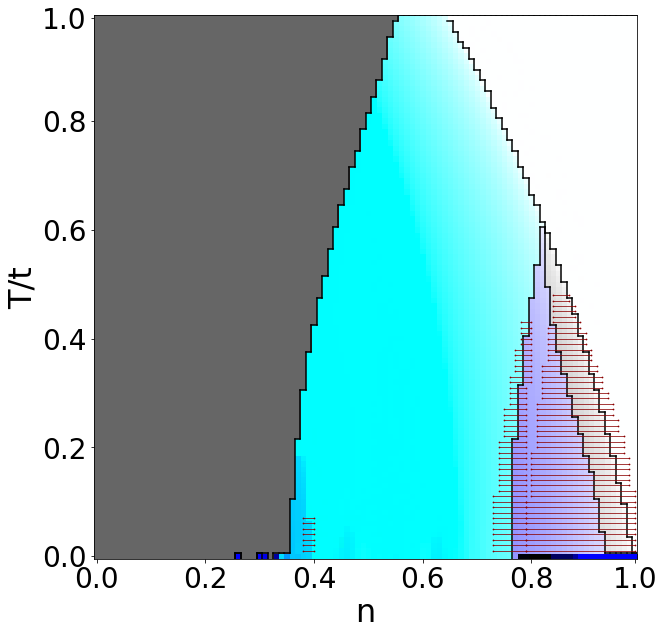

In [8]:
#### The diagram you want
U = 8
two_dimension = False
qq = False

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
interp = 'none'
####
#"UT_grid_triangle.pickle"
#"nT_grid_triangle_u"+ str(U) + ".pickle"
#"nT_grid" + ("" if two_dimension else "_3D") +"_u"+ str(U) + ".pickle"
with open("nT_grid" + ("" if two_dimension else "_3D") +"_u"+ str(U) + ".pickle", 'rb') as input:
    res_dict = pickle.load(input)
    
phase_dict, mag_dict, nr, Tr, e_dict,mu_dict = get_interpreted_data(res_dict,twoD=two_dimension,only_qq=qq)

plt.rc('axes', titlesize=32)     # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels

plt.figure(figsize=[15,10])

#plt.subplot(221)
plot_phase_diagram(phase_dict, mag_dict, nr, Tr, e_dict,mu_dict, sep_q=False, mag_only=False, mag_alpha=False, \
                   twoD=two_dimension,interp=interp)
#plt.title("Color separated phases")
#
#
#plt.subplot(222)
#plot_phase_diagram(phase_dict, mag_dict, nr, Tr, e_dict, mu_dict, sep_q=False, mag_only=False, mag_alpha=False, \
#                   twoD=two_dimension, interp=interp)
#plt.title("Continuous color phases")
#
#plt.subplot(223)
#plot_phase_diagram(phase_dict, mag_dict, nr, Tr, e_dict, mu_dict, sep_q=True, mag_only=False, mag_alpha=True, \
#                   twoD=two_dimension, interp=interp)
#plt.title("Color separated phases, magnetisation alpha")
#
#plt.subplot(224)
#plot_phase_diagram(phase_dict, mag_dict, nr, Tr, e_dict, mu_dict, sep_q=False, mag_only=False, mag_alpha=True, \
#                   twoD=two_dimension, interp=interp)
#plt.title("Continuous color phases, magnetisation alpha")

#plt.suptitle("Cubic lattice phase diagram\n(U="+str(U)+")")
plt.show()

## Phase separation

[0.99167802 1.02419817 0.99310782 1.00342316 1.0015643  0.99804195
 1.00363212 1.00306142 1.00036293 0.99339847 1.00073195 1.00419738
 1.00240463 1.00009429 0.99926096 0.99924367 0.99818436 0.99906227
 1.00140201 1.00187446]


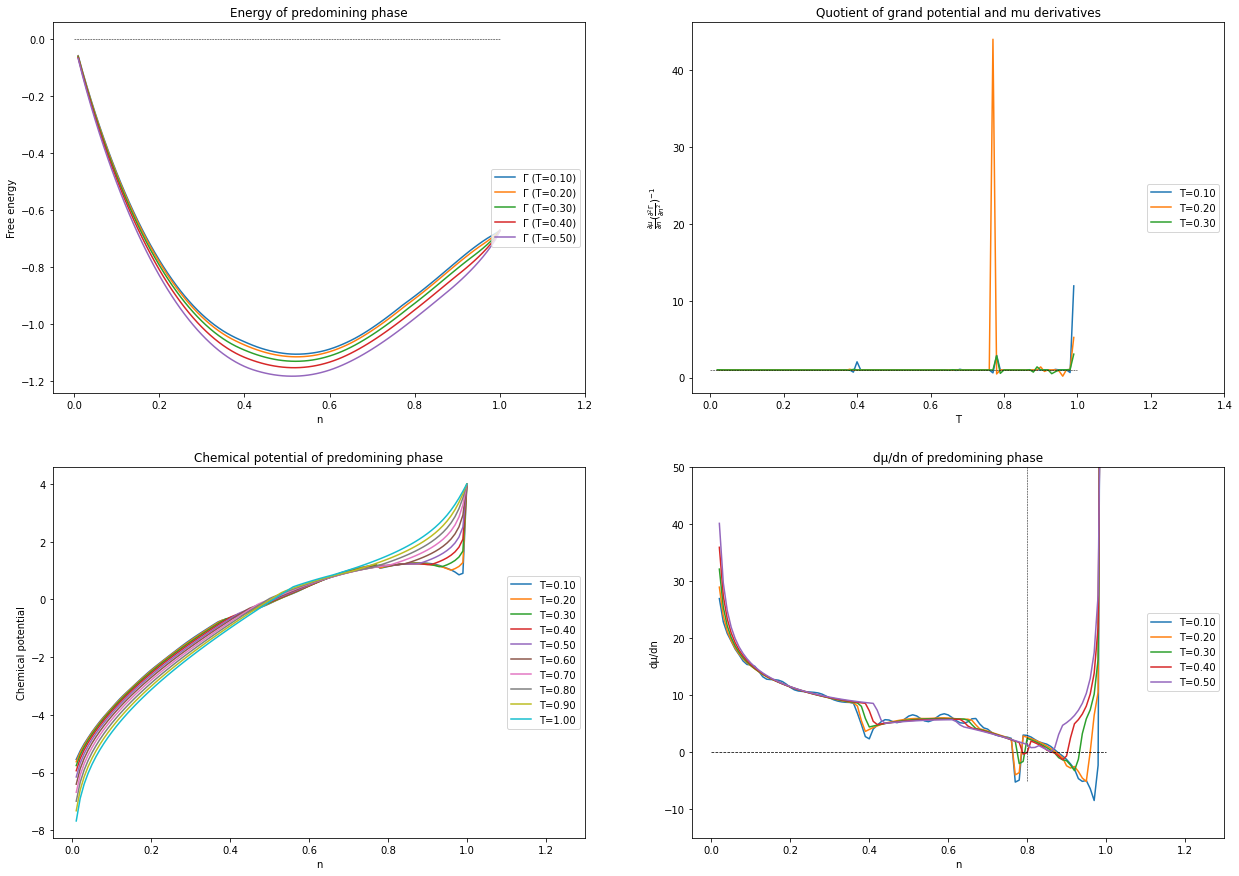

In [12]:
U = 8
two_dimension = False
qq = False


####
#"UT_grid_triangle.pickle"
#"nT_grid_triangle_u"+ str(U) + ".pickle"
#"nT_grid" + ("" if two_dimension else "_3D") +"_u"+ str(U) + ".pickle"
with open("nT_grid" + ("" if two_dimension else "_3D") +"_u"+ str(U) + ".pickle", 'rb') as input:
    res_dict = pickle.load(input)
    
phase_dict, mag_dict, nr, Tr, e_dict, mu_dict = get_interpreted_data(res_dict,twoD=two_dimension,only_qq=qq)
nr = np.array(nr)
Tr = np.array(Tr)


plt.figure(figsize=[21,15])


# ---- Γ(n) and d²Γ/dn² ---- #
plt.subplot(221)

for T_idx in range(9, 59, 10):
    Γ = np.array([e_dict[n,Tr[T_idx]] for n in nr])
    dΓ = (Γ[2:] + Γ[:-2] - 2*Γ[1:-1])/np.square(nr[1] - nr[0])
    plt.plot(nr, Γ, label=f"Γ (T={Tr[T_idx]:1.2f})")
    #plt.plot(nr[1:-1], dΓ, label=f"d²Γ/dn² (T={Tr[T_idx]:1.2f})")


plt.plot([0.,1.0], [0.,0.], '--k', linewidth=0.5)

plt.legend(loc = 'right')
plt.xlabel("n")
plt.xlim([-0.05, 1.2])
#plt.ylim([-1.5,0])
plt.ylabel("Free energy")
plt.title(f"Energy of predomining phase")



# ---- d²Γ/dn² and dµ/dn ---- #
plt.subplot(222)

for T_idx in range(9, 39, 10):
    Γ = np.array([e_dict[n,Tr[T_idx]] for n in nr])
    dΓ = (Γ[2:] + Γ[:-2] - 2*Γ[1:-1])/np.square(nr[1] - nr[0])

    µ = np.array([mu_dict[n,Tr[T_idx]] for n in nr])
    dµ = (µ[2:]-µ[:-2])/(nr[2:]-nr[:-2])
    
    plt.plot(nr[1:-1], dµ/dΓ, label=f"T={Tr[T_idx]:1.2f}")
    
    if T_idx == 9: print((dµ/dΓ)[:20])
    
plt.plot([0.,1.0], [1.0,1.0], '--k', linewidth=0.5)    

plt.legend(loc = 'right')
plt.xlabel("T")
plt.xlim([-0.05, 1.4])
plt.ylabel(r"$\frac{\partial\mu}{\partial n}(\frac{\partial^2\Gamma}{\partial n^2})^{-1}$")
plt.title("Quotient of grand potential and mu derivatives")



# ---- µ(n) ---- #
plt.subplot(223)

for T_idx in range(9, 109, 10):
    mu = np.array([mu_dict[n,Tr[T_idx]] for n in nr])
    
    plt.plot(nr,mu, label=f"T={Tr[T_idx]:1.2f}")

plt.legend(loc = 'right')
plt.xlabel("n")
plt.xlim([-0.05, 1.3])
plt.ylabel("Chemical potential")
plt.title(f"Chemical potential of predomining phase")



#dn/dµ (n)
plt.subplot(224)

for T_idx in range(9, 59, 10):
    mu = np.array([mu_dict[n,Tr[T_idx]] for n in nr])
    dmu = (mu[2:]-mu[:-2])/(nr[2:]-nr[:-2])
    plt.plot(nr[1:-1], dmu, label=f"T={Tr[T_idx]:1.2f}")

plt.plot([0.0, 1.0], [0,0], "--k", linewidth=0.75)    
plt.plot([0.8,0.8], [-5,50], '--k', linewidth=0.5)

plt.legend(loc = 'right')
plt.ylabel("dµ/dn")
plt.ylim([-15,50])
plt.xlim([-0.05, 1.3])
plt.xlabel("n")
plt.title(f"dµ/dn of predomining phase")

plt.show()

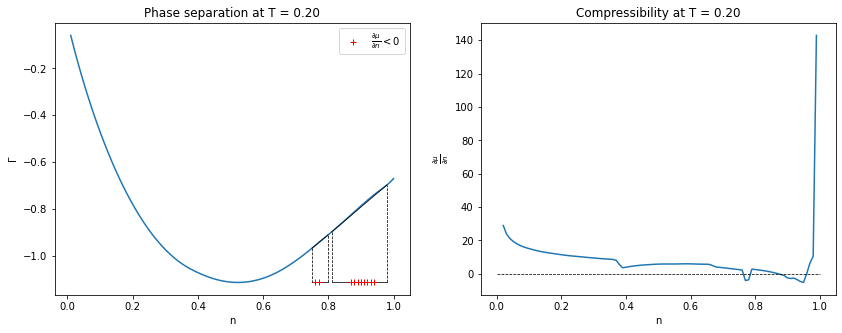

In [15]:
T_idx = 19

phase_dict, mag_dict, nr, Tr, e_dict, mu_dict = get_interpreted_data(res_dict,twoD=two_dimension,only_qq=qq)

Γ = np.array([e_dict[n,Tr[T_idx]] for n in nr])
µ = np.array([mu_dict[n,Tr[T_idx]] for n in nr])
dµ = (µ[2:]-µ[:-2])/(nr[2:]-nr[:-2])

def get_chords(nr,Γ):
    chords = []

    # ---- Register all valid chords ---- #
    for start_idx in range(len(Γ)):
        for end_idx in range(start_idx + 2, len(Γ)):

            # ---- Chord equation ---- #
            a = (Γ[end_idx] - Γ[start_idx]) / (nr[end_idx] - nr[start_idx])
            b = (Γ[start_idx]*nr[end_idx] - Γ[end_idx]*nr[start_idx]) / (nr[end_idx] - nr[start_idx])

            # ---- Chord under the energy everywhere ? ---- #
            for middle_idx in range(start_idx + 1, end_idx):
                if Γ[middle_idx] < a*nr[middle_idx] + b:
                    break
            else:
                chords.append((start_idx, end_idx))

    final_chords = []

    # ---- Test if the chord is included in another ---- #
    for chord in chords:
        for test_chord in chords:
            if chord == test_chord:
                continue
            if test_chord[0] <= chord[0] and chord[1] <= test_chord[1]:
                break
        else:
            final_chords.append(chord)

    return final_chords


phase_sep = get_chords(nr,Γ)

m = min(Γ)

plt.figure(figsize=[14,5])

plt.subplot(121)
plt.plot(nr,Γ)
for i,j in phase_sep:
    
    plt.plot([nr[i], nr[j]], [Γ[i], Γ[j]], "-k", linewidth=0.75)
    plt.plot([nr[i], nr[j]], [m]*2, "-k", linewidth=0.75)
    plt.plot([nr[i], nr[i]], [Γ[i], m], "--k", linewidth=0.75)
    plt.plot([nr[j], nr[j]], [m, Γ[j]], "--k", linewidth=0.75)
    
plt.plot([nr[i] for i, der in enumerate(dµ) if der < 0], [m for i, der in enumerate(dµ) if der < 0], \
         "+r", label=r"$\frac{\partial\mu}{\partial n} < 0$")
    
plt.xlabel("n")
plt.ylabel(r"$\Gamma$")
plt.title(f"Phase separation at T = {Tr[T_idx]:1.2f}")
plt.legend()


plt.subplot(122)


plt.plot(nr[1:-1], dµ, label=f"T={Tr[T_idx]:1.2f}")
plt.plot([0,1], [0,0], "--k", linewidth=0.75)

plt.xlabel("n")
plt.ylabel(r"$\frac{\partial\mu}{\partial n}$")
plt.title(f"Compressibility at T = {Tr[T_idx]:1.2f}")

plt.show()

## Divers

In [ ]:
limit = list()
for T_i, T in enumerate(Tr):
    for n_i, n in enumerate(nr[:-1]):
        if phase_dict[n,T] == 'PM' and phase_dict[nr[n_i+1],T] != 'PM':
            limit.append(((n+nr[n_i+1])/2,T))
            break;
#print(limit)
plt.plot([l[1] for l in limit],[l[0] for l in limit], '-+')
#print(len(limit))

with open("PM_limit_120_lattice.pickle", "wb") as output:
    pickle.dump(limit,output)
    
with open("PM_limit_120_lattice.pickle", "rb") as input:
    limit2 = pickle.load(input)
    
#print(limit == limit2)

In [ ]:
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

In [ ]:
phases = [phase_dict[n,Tr[1]] for n in nr]

print(phase_dict[nr[55],Tr[40]])
print(nr[56],Tr[40])
#print([q for q in phases if type(q) == tuple and q[0] != q[1]])

ordi_x = [0 if pha == 'PM' else 1 if pha == 'FM' else pha[0]/(2*np.pi) for pha in phases]
ordi_y = [0 if pha == 'PM' else 1 if pha == 'FM' else pha[1]/(2*np.pi) for pha in phases]
ener_qq = [ res_dict[nr[n_i],Tr[1],"energy","qq"] for n_i in range(len(nr))]
ener_piq = [ res_dict[nr[n_i],Tr[1],"energy","piq"] for n_i in range(len(nr))]

plt.plot(nr,ordi_x, '-+',label="qx")
plt.plot(nr,ordi_y, '-+',label="qy")
plt.plot(nr,ener_qq,label="qq energy")
plt.plot(nr,ener_piq,label="piq energy")

plt.xlabel("U")
plt.ylabel("q / 2π")

plt.legend()
plt.show()

#print([nr[i] for i in range(len(phases)) if (type(phases[i]) == tuple and phases[i][0] != phases[i][1])])

In [ ]:
res_dict

### Plot energy in FBZ

In [ ]:
with open("Q_grid.pickle", 'rb') as input:
    res_dict = pickle.load(input)

Qx_set = set()
Qy_set = set()
for key in res_dict:
    Qx_set.add(key[0])
    Qy_set.add(key[1])

Qxr = list(Qx_set)
Qxr.sort()
Qyr = list(Qy_set)
Qyr.sort()

#Determine the q vector with lowest energy
e_dico = {(qx,qy): res_dict[qx,qy, "energy"] for qx in Qxr for qy in Qyr}
Q = min(e_dico, key = e_dico.get)
min_e = e_dico[min(e_dico)]
max_e = e_dico[max(e_dico)]
#print(Q[0]/np.pi, Q[1]/np.pi)
#print(e_dico)

diagram = np.zeros((len(Qxr), len(Qyr),3))
for qx_i,qx in enumerate(Qxr):
    for qy_i,qy in enumerate(Qyr):
        diagram[qx_i,qy_i,0] = (res_dict[qx,qy, "energy"] - max_e)/(max_e - min_e)
#plt.imshow(diagram)

plt.plot(Qxr,[e_dico[qx,Qyr[35]] for qx in Qxr])

#np.max(diagram)


In [ ]:
U = 8
two_dimension = True
qq = False

with open("UT_grid_triangle_64.pickle", 'rb') as input:
    res_dict = pickle.load(input)
    
phase_dict, mag_dict, nr, Tr = get_interpreted_data(res_dict,twoD=two_dimension,only_qq=qq)

plt.figure(figsize=[15,10])

plt.subplot(1,2,1)
plot_phase_diagram(phase_dict, mag_dict, nr, Tr, sep_q=False, mag_only=False, mag_alpha=False,twoD=two_dimension, \
                  interp=interp)
plt.title("Continuous color phases, 64-sized lattice")



with open("UT_grid_triangle_128.pickle", 'rb') as input:
    res_dict = pickle.load(input)
    
phase_dict, mag_dict, nr, Tr = get_interpreted_data(res_dict,twoD=two_dimension,only_qq=qq)

plt.subplot(1,2,2)
plot_phase_diagram(phase_dict, mag_dict, nr, Tr, sep_q=False, mag_only=False, mag_alpha=False,twoD=two_dimension, \
                  interp=interp)
plt.title("Continuous color phases, 128-sized lattice")